In [1]:
from scipy.integrate import solve_ivp
from scipy.integrate import ode
import numpy as np
from matplotlib import pyplot as plt

In [2]:
S=276618
V=599864
W=97500
E=390
EB=39
I=974
IB=97
ICU=18
R=24500

UC=0.65*1000000
WC=0.005*1000000
H=ICU

y0 = [S,V,W,E,EB,I,IB,ICU,R,UC,WC]
y0H = [S,V,W,E,EB,I,IB,ICU,R,UC,WC,H]

M = sum(y0[:-2])

Rt_base = 3     # 0. - 3.5
ramping = 1
eta = 0.5
#kappa =0# 0.5 - 0.85
kappa = 0.9      # 0.7 - 0.95
sigma = 0.5      # 0.5 - 1.

gamma = 0.1      # 0.088 - 0.1
gamma_ICU = 0.1  # 0.08 - 0.2
delta = 0.007   # 0.00001 - 0.007
rho = 0.25

omega_v_b = 1./(6*30)
omega_n_b = 1./(12*30)

chi_0 = 0.1
chi_1 = 0.2

alpha_w = 0.008 # 0.005
alpha_u = 0.01
alpha_R = 8e-3 # 5e-3

n = 1.
k_v = M*omega_v_b*(1/(gamma+delta))
k_n = M*omega_n_b*(1/(gamma+delta))

#L_w = alpha_w
#L_omega_v = 1/k_v
#L_omega_n = 1/k_n

e_R = 0.
e_u = 0.
e_w = 0.

Phi_0 = 0.0025
phi_0 = 0.0025


u_base = 0.5
w_max = 1-chi_1


#lamb2 = 6 #a parameter that is used if we go for the logistic approach 



tau_vac = 6*7 # from shot to immunization
tau_behaviour = 60
mu=0
#mu = 0.267
d_0 = 274
d_mu = 0.

In [3]:
d = {'S':0,'V':1,'W':2,'E':3,'EB':4,'I':5,'IB':6,'ICU':7,'R':8,'UC':9,'WC':10}
def fun(t,y):
    (S,V,W,E,EB,I,IB,ICU,R,UC,WC) = y
    
    I_eff = I + sigma*IB
    Gamma = 1 + mu*np.cos(2*np.pi*(t+d_0-d_mu)/365.)
    Rt = Rt_base*np.exp(-alpha_R*ICU -e_R) * Gamma

    u_max = 1 - chi_0
    u_w = u_base + (u_max-u_base)*(1-np.exp(-alpha_u*ICU-e_u))
    Phi = 0 if u_w<UC/M else min(Phi_0,u_w-UC/M)

    w_w = w_max*(1 - np.exp(-alpha_w*ICU-e_w))
    phi = 0 if w_w<WC/M else min(phi_0,WC/M)

    omega_v = omega_v_b*(1-(I_eff**n/((k_v/2)**n+I_eff**n)))
    omega_n = omega_n_b*(1-(I_eff**n/((k_n/2)**n+I_eff**n)))
    
    dS = -gamma*Rt*S/M*I_eff - Phi*M
    dV = -(1-eta)*gamma*Rt*V/M*I_eff + (Phi+phi)*M - omega_v*V
    dW = omega_v*V - gamma*Rt*W/M*I_eff - phi*M + omega_n*R
    dE = gamma*Rt*(S+W)/M*I_eff - rho*E
    dEB = (1-eta)*gamma*Rt*V/M*I_eff - rho*EB
    dI = rho*E - (gamma+delta)*I
    dIB = rho*EB - (gamma + delta*(1-kappa))*IB
    dICU = delta*(I+(1-kappa)*IB) - gamma_ICU*ICU
    dR = gamma*(I+IB) - omega_n*R + gamma_ICU*ICU
    dUC = M*Phi
    dWC = M*phi
    
    return [dS,dV,dW,dE,dEB,dI,dIB,dICU,dR,dUC,dWC]

In [4]:
def funH(t,y):
    (S,V,W,E,EB,I,IB,ICU,R,UC,WC,H) = y
    
    I_eff = I + sigma*IB
    Gamma = 1 + mu*np.cos(2*np.pi*(t+d_0-d_mu)/365.)
    Rt = Rt_base*np.exp(-alpha_R*ICU -e_R) * Gamma

    u_max = 1 - chi_0
    u_w = u_base + (u_max-u_base)*(1-np.exp(-alpha_u*H-e_u))
    Phi = 0 if u_w<UC/M else min(Phi_0,u_w-UC/M)

    w_w = w_max*(1 - np.exp(-alpha_w*H-e_w))
    phi = 0 if w_w<WC/M else min(phi_0,WC/M)

    omega_v = omega_v_b*(1-(I_eff**n/((k_v/2)**n+I_eff**n)))
    omega_n = omega_n_b*(1-(I_eff**n/((k_n/2)**n+I_eff**n)))
    
    dS = -gamma*Rt*S/M*I_eff - Phi*M
    dV = -(1-eta)*gamma*Rt*V/M*I_eff + (Phi+phi)*M - omega_v*V
    dW = omega_v*V - gamma*Rt*W/M*I_eff - phi*M + omega_n*R
    dE = gamma*Rt*(S+W)/M*I_eff - rho*E
    dEB = (1-eta)*gamma*Rt*V/M*I_eff - rho*EB
    dI = rho*E - (gamma+delta)*I
    dIB = rho*EB - (gamma + delta*(1-kappa))*IB
    dICU = delta*(I+(1-kappa)*IB) - gamma_ICU*ICU
    dR = gamma*(I+IB) - omega_n*R + gamma_ICU*ICU
    dUC = M*Phi
    dWC = M*phi
    dH = ( data[int((t+tau_behaviour)/step_size)][7] - data[int(t/step_size)][7] ) / tau_behaviour
    #(ICU(t-t_vac) - ICU(t-t_vac-t_behavior))/tau
    
    return [dS,dV,dW,dE,dEB,dI,dIB,dICU,dR,dUC,dWC,dH]

In [5]:
t_max = 365
step_size = 0.1
times = np.arange(0,t_max,step_size)

In [6]:
data = [y0H]*int((tau_vac+tau_behaviour)/step_size)

for i in range(len(times)-1):
    res = solve_ivp(funH, (times[i],times[i+1]), data[-1])
    data.append( res["y"][:,-1:].reshape(12) )

data = np.array(data)[-int(t_max/step_size):,:]

In [7]:
result = solve_ivp(fun, (0,t_max), y0, t_eval=times)

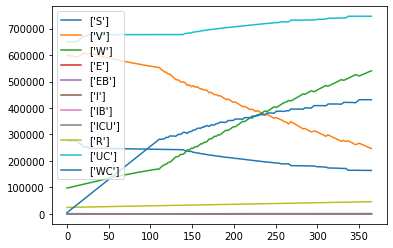

In [8]:
for i,x in enumerate(result["y"]):
    plt.plot(result["t"],x,label=[k for k,v in d.items() if v == i])
plt.legend()

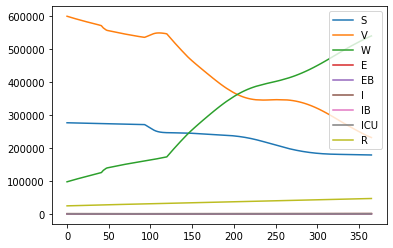

In [9]:
labels = ['S','V','W','E','EB','I','IB','ICU','R']
for i,x in enumerate(labels):
    plt.plot(times,data[:,i],label=x)
plt.legend()

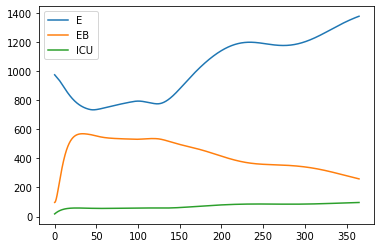

In [10]:
plt.plot(times,data[:,5],label="E")
plt.plot(times,data[:,6],label="EB")
plt.plot(times,data[:,7],label="ICU")
plt.legend()

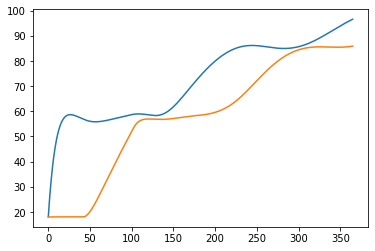

In [11]:
plt.plot(times,data[:,7],label="ICU")
plt.plot(times,data[:,-1],label="H")

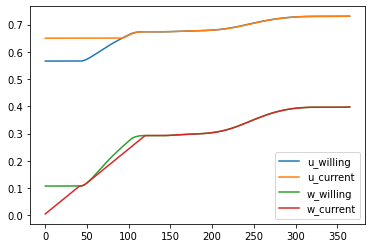

In [12]:
def u_max():
    return 1 - chi_0
def u_w(ICU):
    return u_base + (u_max()-u_base)*(1-np.exp(-alpha_u*ICU-e_u))
def w_w(ICU):
    return w_max*(1-np.exp(-alpha_w*ICU-e_w))

plt.plot(times, u_w(data[:,11]), label='u_willing')
plt.plot(times, 1/M*data[:,9], label='u_current')
#plt.plot(result.t, u_c(result.y[d['S']]), label='u_current')
plt.plot(times, w_w(data[:,11]), label='w_willing')
plt.plot(times, 1/M*data[:,10], label='w_current')
#plt.plot(result.t, w_c(result.y[d['W']], result.y[d['S']]), label='w_current')
plt.legend()

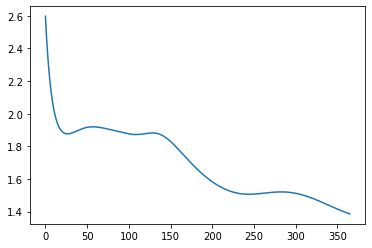

In [13]:
def Gamma(t):
    return 1 + mu*np.cos(2*np.pi*(t+d_0-d_mu)/365.)
def Rt(Rt_base, ICU, t):
    return Rt_base*np.exp(-alpha_R*ICU -e_R) * Gamma(t)
plt.plot(times, Rt(Rt_base,data[:,7],times), label='Rt')

In [14]:
def Phi(ICU,UC):
    if u_w(ICU) < UC/M: return 0
    return min(Phi_0, u_w(ICU)-UC/M)
def phi(ICU,WC):
    if w_w(ICU) < WC/M: return 0
    return min(phi_0, w_w(ICU)-WC/M)
plt.plot(times, (Phi(data[:,7],data[:,9])+phi(data[:,7],data[:,10]))*M, label="daily vac")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
sum(result['y'])

In [ ]:
data[:,:-3].sum(axis=1)